## Script to extract the files (photos) from within folders.

#### Note DOES NOT need to be ran again

In [ ]:
# adding access to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Data

### https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [ ]:
import os
import shutil
import pandas as pd
import sklearn
import random
random.seed(2)

import torch 
import torchvision

# cv2 to view images
import cv2

#Ideally have the same version numbers or similar
!python --version #3.7.13
print(torch.__version__) # 1.11.0+cu113
print(np.__version__) # 1.21.6
print(sklearn.__version__) # 1.0.2

In [ ]:
# ## TESTING DONT RUN CAN ONLY BE RAN ONCE ****
# # extract the subfolders from the main folder
RUN = False
if RUN:
  dataset = r"/content/drive/MyDrive/comp472-MaskDetector/Dataset"
  path_subfolders = [f.path for f in os.scandir(dataset) if f.is_dir()]

  print(path_subfolders)

  train_dir = path_subfolders[0]
  #test_dir = path_subfolders[0]
  val_dir = path_subfolders[1]

  # # extract subfolders from subfolders
  path_trainsubfolders = [f.path for f in os.scandir(train_dir) if f.is_dir()]
  #path_testsubfolders = [f.path for f in os.scandir(test_dir) if f.is_dir()]
  path_valsubfolders = [f.path for f in os.scandir(val_dir) if f.is_dir()]
  print(path_valsubfolders)

  # # # for each subfolder in subfolders, grab files from src path (subfolder) and move it to destination folder
  for subPath in path_subfolders: # train, test, val

    if subPath == train_dir:

      for subs in path_trainsubfolders: # nomask, mask
        for f in os.listdir(subs):
          # grab file from original dir
          src = os.path.join(subs, f)
          #create unique name for file
          new_file = str(random.random())+f
          # place file in main dataset
          dst = os.path.join(dataset, new_file) #
          shutil.move(src, dst)

        ## remove subfolder    
        shutil.rmtree(subs)




      if subPath == test_dir:

        for sub in path_testsubfolders: # nomask, mask
            for f in os.listdir(sub):
              # grab file from original dir
              src = os.path.join(sub, f)
              #create unique name for file
              new_file = str(random.random())+f
              # place file in main dataset
              dst = os.path.join(dataset, new_file) #
              shutil.move(src, dst)

      #     # remove subfolder    
            shutil.rmtree(sub)
      
      if subPath == val_dir:

        for sub in path_valsubfolders: # nomask, mask
                
          for f in os.listdir(sub):
            # grab file from original dir
            src = os.path.join(sub, f)
            #create unique name for file
            new_file = str(random.random())+f
            # place file in main dataset
            dst = os.path.join(dataset, new_file) #
            shutil.move(src, dst)

          # remove subfolder    
          shutil.rmtree(sub)

      shutil.rmtree(subPath)


In [ ]:
list = os.listdir(dataset) 
number_files = len(list)
print(number_files)

11969


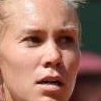

In [ ]:
# View a sample Image
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/comp472-MaskDetector/Dataset/0.000450885337116901933102.png")
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans

# func to extract features using transfer learning 
def image_features(dataset):
  model = InceptionV3(weights='imagenet', include_top=False)
  features = [];
  img_name = [];
  for i in os.listdir(dataset):
      img=os.path.join(dataset, i)
      new_img=image.load_img(img, target_size=(100,100))
      x = img_to_array(new_img)
      x=np.expand_dims(x,axis=0)
      x=preprocess_input(x)
      feat=model.predict(x)
      feat=feat.flatten()
      features.append(feat)
      img_name.append(i)
  return features,img_name

img_features,img_name=image_features(dataset)

In [ ]:
#Creating Clusters
k = 4
clusters = KMeans(k, random_state = 40)
clusters.fit(img_features)

In [ ]:
image_cluster = pd.DataFrame(img_name,columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster

In [ ]:
image_cluster['clusterid'].value_counts()

In [ ]:
# Made folder to seperate images
os.mkdir(dataset+"/"+'noMask')
os.mkdir(dataset+"/"+'clothMask')
os.mkdir(dataset+"/"+'surgicalMask')
os.mkdir(dataset+"/"+'N95Mask')

# # Images will be seperated according to cluster they belong
for i in range(len(image_cluster)):
    if image_cluster['clusterid'][i]==0:
        shutil.move(os.path.join(dataset, image_cluster['image'][i]), dataset+"/"+'surgicalMask')
    elif image_cluster['clusterid'][i]==1:
        shutil.move(os.path.join(dataset, image_cluster['image'][i]), dataset+"/"+'noMask')
    elif image_cluster['clusterid'][i]==2:
        shutil.move(os.path.join(dataset, image_cluster['image'][i]), dataset+"/"+'clothMask')
    elif image_cluster['clusterid'][i]==3:
        shutil.move(os.path.join(dataset, image_cluster['image'][i]), dataset+"/"+'N95Mask')

In [ ]:
# resize images to (32,32,3) so they're all the same size. Original size ~(100,100,3)
import PIL
from PIL import Image

path_subfolders = [f.path for f in os.scandir(dataset) if f.is_dir()]

# print(cv2.imread("/content/drive/MyDrive/comp472-MaskDetector/fake dataset/N95Mask1/Copy of 0.012824260849167102Augmented_833_8634013.png").shape)

# for every image in each subfolder,resize images to (32,32,3) so they're all the same size. Original size ~(100,100,3)
for subfolder in path_subfolders: 
  for file in os.listdir(subfolder):
    f_img = subfolder+"/"+file
    img = Image.open(f_img)
    img = img.resize((32,32))
    img.save(f_img)
